# Análise Exploratória do Dataset

**Disciplina:** Redes Neurais Artificiais 2025.1

**Professora orientadora:** 
Elloa B. Guedes (ebgcosta@uea.edu.br)

**Integrantes da equipe:**
* Adriana Raffaella Dos Santos Fonseca (ardsf.eng23@uea.edu.br)
* Ana Flavia De Castro Segadilha Da Silva (afdcsds.eng23@uea.edu.br)
* Davi Aguiar Moreira (dam.eng23@uea.edu.br)
* Guilherme Goncalves Moraes (ggm.eng23@uea.edu.br)
* Ian Garrido Reis (igr.eng23@uea.edu.br)
* Luiz Fernando Borges Brito (lfbb.eng23@uea.edu.br)
* Pedro Vitor Barros Maranhão (pvbm.eng23@uea.edu.br)
* Rita De Cassia Brasil Alves (rdcba.eng23@uea.edu.br)
* Yago De Oliveira Feitoza (ydof.eng21@uea.edu.br)

---

Iniciado no ano 2000 e atualmente em sua quinta fase, o Sloan Digital Sky Survey (SDSS) se trata de um projeto de levantamento astronômico com o objetivo de mapear tridimensionalmente um quarto do céu estrelado. Tal projeto disponibiliza resultados obtidos por seus telescópios à comunidade científica através do servidor SkyServer. 

Nesse contexto, o presente projeto faz uso de uma base de dados proveniente de tal servidor. Esta armazena um total 100.000 amostras, com 17 features e uma classificação do corpo celeste em galaxia, quasar ou estrela.

O dataset foi disponibilizado na plataforma Kaggle em 2022, através do seguinte link: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17/data.

## **Importação das bibliotecas**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing

## **Importação do Dataset**

In [8]:
file_path = 'star_classification.csv'

In [9]:
original_df = pd.read_csv(file_path)
original_df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


Confirmação de que o dataset apresenta 100mil amostras com dados dispostos em 18 colunas.

In [11]:
original_df.shape

(100000, 18)

Confirmação de que há apenas 3 classes possíveis para o atributo alvo: galaxia, quasar e estrela.

In [13]:
original_df['class'].unique()

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

## **Análise das colunas do dataset**

In [15]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

O dataset apresenta um total de 18 colunas, mas nem todas podem ser utilizadas como preditores para o problema de classifição multiclasse. Isso porque algumas colunas são meros identificadores, sendo únicos para cada exemplo e, portanto, desnecessários para um treinamento de machine learning. São esses:
* obj_ID é um identificador dentro do catálogo de origem do dataset;
* alpha e delta são atributos de localização;
* run_ID, rerun_ID e cam_col são identificadores técnicos do SDSS;
* spec_obj_ID é um identificar para dois registros de um mesmo objeto, o que não ocorre no dataset;
* MJD se trata apenas da data do registro;
* fiber_ID, field_ID e plate são campos que dependem do modo como áreas de observação, fibras ópticas e placas utilizadas para captura das imagens são registrados no SDSS, o que tornaria o modelo dependente dos dados do SDSS. 

Além disso, é necessário remover dados de coordenadas, os quais podem influenciar a análise em relação à posição do corpo celeste em detrimento das características ópticas do corpo. Dessa forma, são retirados do dataset as seguintes colunas: 
* alpha - Right Ascension angle (RA) - Coordenada astronômica equivalente à longitude celestial - varia entre 0º e 360º;
* delta - Declination angle (DEC) - Coordenada astronômica equivalente à latitude celestial - varia entre -90º e +90º;

## **Remoção de atributos identificadores**

In [18]:
columns_to_remove = ['obj_ID', 'alpha', 'delta', 'run_ID', 'rerun_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'fiber_ID', 'field_ID', 'plate']
df = original_df.drop(columns=columns_to_remove)

In [19]:
df.shape

(100000, 7)

Após a remoção dos identificadores, restaram 8 atributos preditores. Todos estão relacionados com as características visuais do corpo celeste. São estes:
* u - Magnitude de raios ultravioletas recebidos pelo filtro;
* g - Magnitude de raios do espectro verde recebidos pelo filtro;
* r - Magnitude de raios do espectro vermelho recebidos pelo filtro;
* i - Magnitude de raios próximos ao espectro infravermelho recebidos pelo filtro;
* z - Magnitude de raios infravermelhos recebidos pelo filtro;
* redshift - Interferência na tonalidade vermelha causada pela aproximação ou pelo afastamento do corpo celeste em relação ao telescópio.

## **Alterando posição do atributo alvo no dataset**

In [22]:
df = df.reindex(columns=['u', 'g', 'r', 'i', 'z','redshift','class'])

In [23]:
new_columns = {
    'u':'uv',
    'g':'green',
    'r':'red',
    'i':'near_infrared',
    'z':'infrared',
    'redshift':'redshift',
    'class':'class'}

In [26]:
df = df.rename(columns=new_columns)

In [28]:
df.head()

,uv,green,red,near_infrared,infrared,redshift,class
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,GALAXY
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,GALAXY
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,GALAXY
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,GALAXY
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,GALAXY


In [34]:
df.describe()

,uv,green,red,near_infrared,infrared,redshift
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,21.980468,20.531387,19.645762,19.084854,18.668810,0.576661
std,31.769291,31.750292,1.854760,1.757895,31.728152,0.730707
min,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,-0.009971
25%,20.352353,18.965230,18.135828,17.732285,17.460677,0.054517
50%,22.179135,21.099835,20.125290,19.405145,19.004595,0.424173
75%,23.687440,22.123767,21.044785,20.396495,19.921120,0.704154
max,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245


## **Análise de dados faltantes**

In [41]:
print(f'Total de dados faltantes: {df.isna().sum().sum()}')

Total de dados faltantes: 0


## **Remoção de outlier**

Através do describe, percebeu-se a influência de valores tendendo ao infinito negativo(-9999.0000000), esse outlier corresponde a apenas um dado. Visando evitar a interferência de tal valor na análise da dispersão dos dados, o exemplo em questão será removido do dataset.

In [45]:
df.loc[df['uv'] < 0]

,uv,green,red,near_infrared,infrared,redshift,class
79543,-9999.0,-9999.0,18.1656,18.01675,-9999.0,0.000089,STAR


In [47]:
df = df.drop(79543, axis=0)
df = df.reset_index(drop=True)
df

,uv,green,red,near_infrared,infrared,redshift,class
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,GALAXY
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,GALAXY
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,GALAXY
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,GALAXY
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,GALAXY
...,...,...,...,...,...,...,...
99994,22.16759,22.97586,21.90404,21.30548,20.73569,0.000000,GALAXY
99995,22.69118,22.38628,20.45003,19.75759,19.41526,0.404895,GALAXY
99996,21.16916,19.26997,18.20428,17.69034,17.35221,0.143366,GALAXY
99997,25.35039,21.63757,19.91386,19.07254,18.62482,0.455040,GALAXY


In [49]:
df.describe()

,uv,green,red,near_infrared,infrared,redshift
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,22.080679,20.631583,19.645777,19.084865,18.768988,0.576667
std,2.251068,2.037384,1.854763,1.757900,1.765982,0.730709
min,10.996230,10.498200,9.822070,9.469903,9.612333,-0.009971
25%,20.352410,18.965240,18.135795,17.732280,17.460830,0.054522
50%,22.179140,21.099930,20.125310,19.405150,19.004600,0.424176
75%,23.687480,22.123775,21.044790,20.396510,19.921120,0.704172
max,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245


## **Análise da distribuição de atributos preditores**

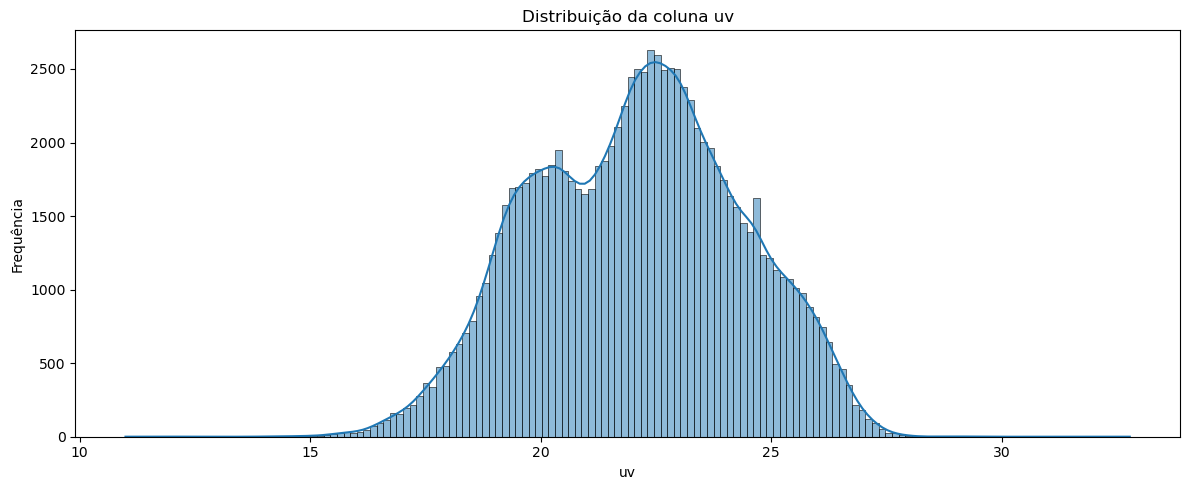

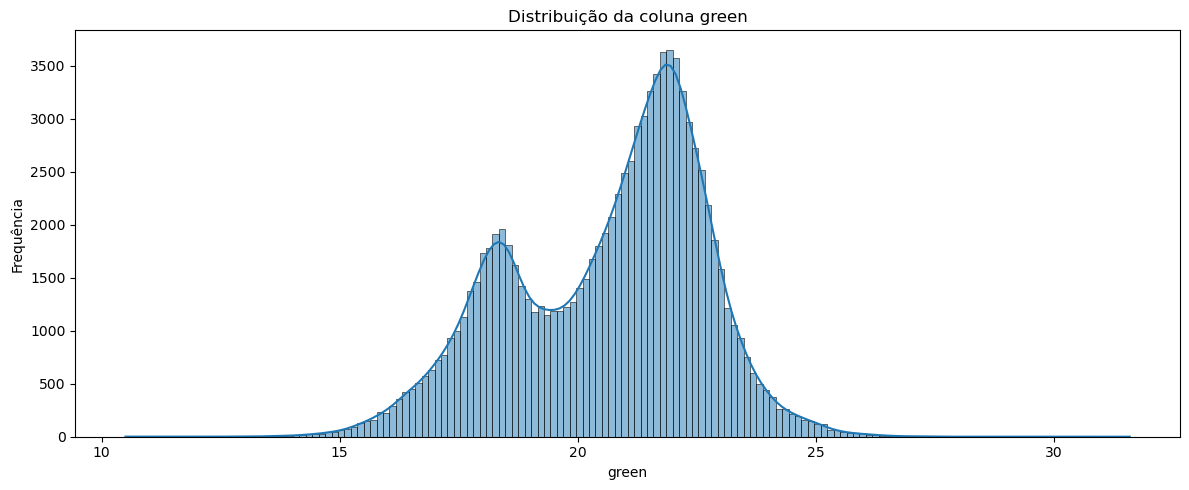

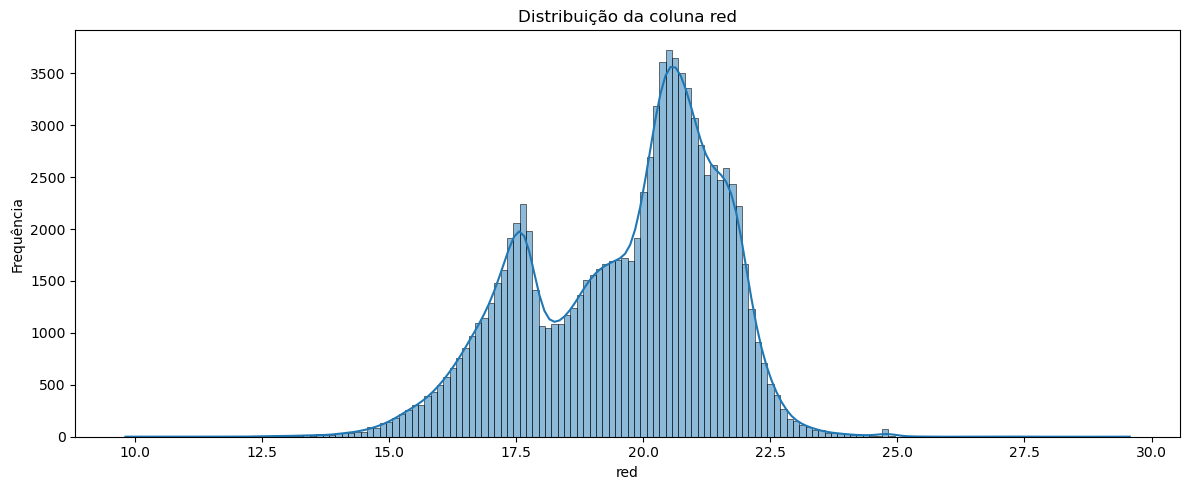

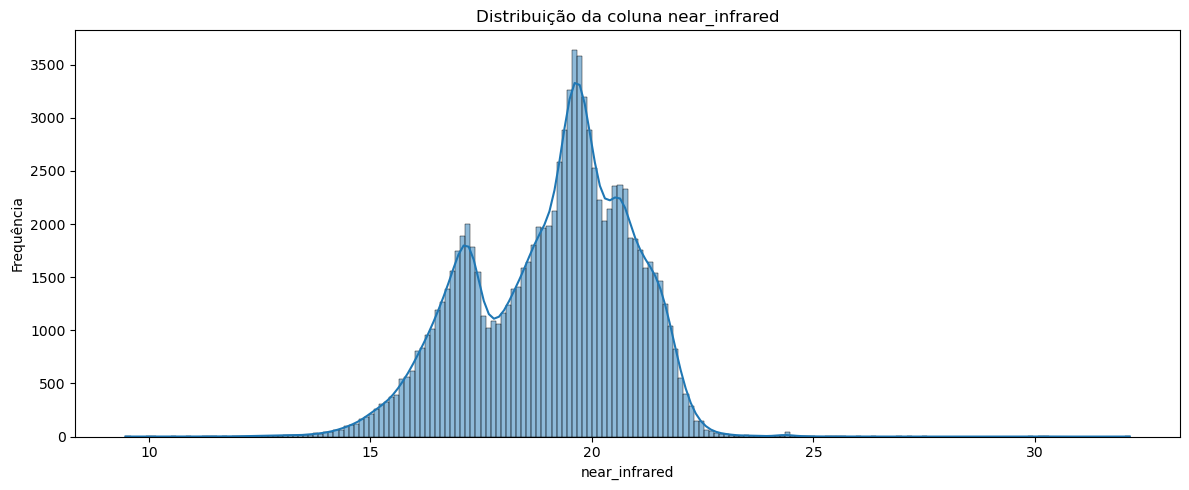

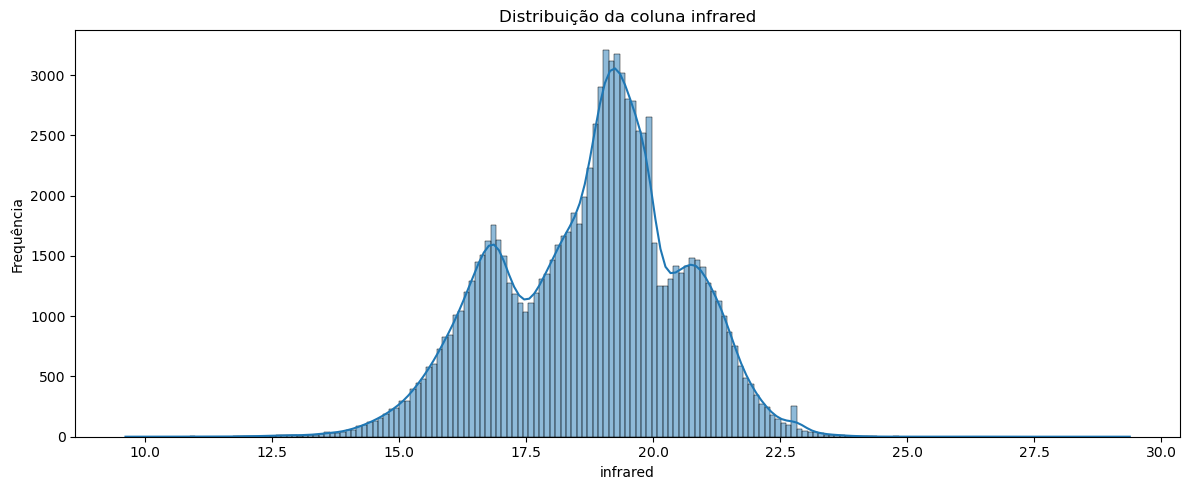

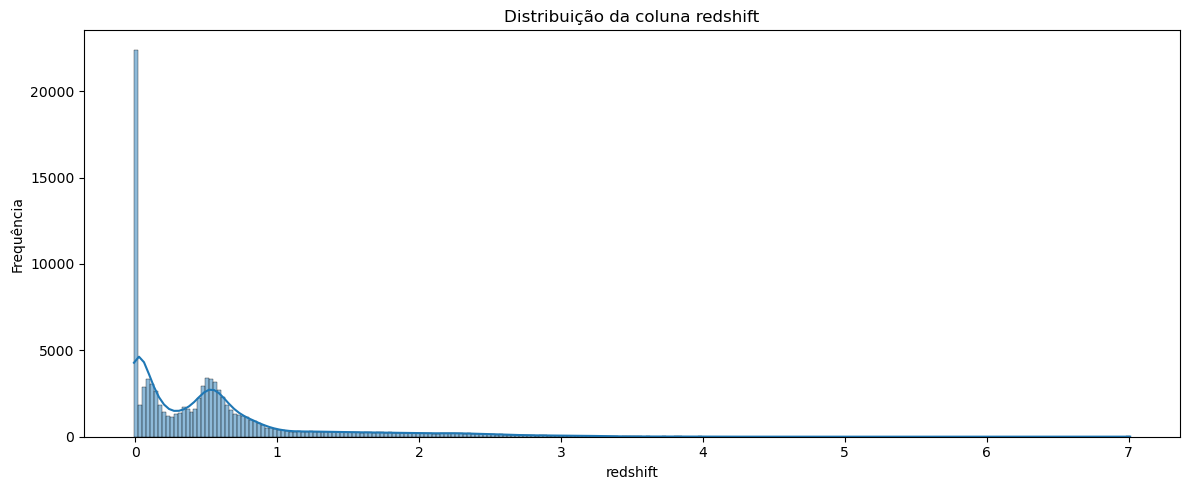

In [52]:
features = df.columns[:-1]

for feature in features:
    plt.figure(figsize=(12, 5))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribuição da coluna {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()
    print()

## **Distribuição das Classes**

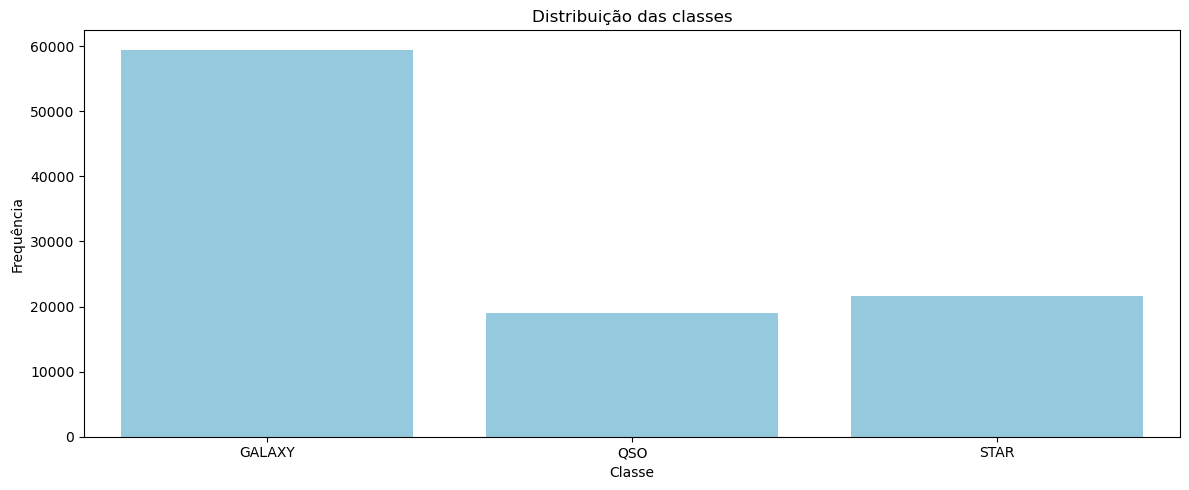

In [56]:
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='class', color='skyblue')
plt.title(f'Distribuição das classes')
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()
print()

Observa-se um desbalanceamento das classes, sendo que a quantidade de quasares e estrelas é aproximada, enquanto a quantidade de galáxias é quase o triplo das demais classes.

## **Codificação das classes**

Diante da tarefa de classificação, nota-se a necessidade de codificação das classes a fim de tornar o dataset mais apropriado para o treinamento de modelos de machine learning. Tal processo consiste em converter as variáveis do tipo string para valores numéricos. Dessa forma, utiliza-se a abordagem One-Hot-Enconding dada a natureza não hierárquica das classes. 

In [45]:
encoder =  sklearn.preprocessing.OneHotEncoder(sparse_output=False)
encoder_df = encoder.fit_transform(df[['class']])
df_encoded = pd.DataFrame(encoder_df)
df_encoded.value_counts()

0    1    2  
1.0  0.0  0.0    59445
0.0  0.0  1.0    21593
     1.0  0.0    18961
Name: count, dtype: int64

In [46]:
df['class'] = df_encoded.idxmax(axis=1)
df

,uv,green,red,near_infrared,infrared,redshift,class
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,0
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,0
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,0
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,0
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,0
...,...,...,...,...,...,...,...
99994,22.16759,22.97586,21.90404,21.30548,20.73569,0.000000,0
99995,22.69118,22.38628,20.45003,19.75759,19.41526,0.404895,0
99996,21.16916,19.26997,18.20428,17.69034,17.35221,0.143366,0
99997,25.35039,21.63757,19.91386,19.07254,18.62482,0.455040,0


In [22]:
df['class'].value_counts()

class
0    59445
2    21593
1    18961
Name: count, dtype: int64

Após a codificação, as classes são descritas de acordo com os seguintes índices:
* 0 - Galaxia
* 1 - Quasar
* 2 - Estrela

## **Armazenamento do dataset modificado**

In [47]:
df.to_csv('modified_star_classification.csv', encoding='utf-8', index=False)